# 重新实现之前的线性热模型
应该只需要读取第一次实验的数据，这里主要想规范一下之前的写法

In [ ]:
import pandas as pd
import numpy as np
import os
from keys import *
import math

from tqdm import tqdm
from loader import Loader
from thermal_model.data import *
from thermal_model.configs import *
from thermal_model.figure_plotter import *
from utils_thermal_model_raw_process import *
import matplotlib.pyplot as plt
from plotter import Plotter
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lars
from sklearn.ensemble import RandomForestRegressor
from thermal_model.thermal_model import fit_random_forest, model_estimator

# 读取数据并且缓存成单独pickle

In [ ]:
df_thermal_model_data_raw = ThermalModelData().load()

# 生成线性模型的输入项

In [ ]:
df_thermal_model_data_input = generate_model_input(df_thermal_model_data_raw)

In [ ]:
df_thermal_model_data_input.columns

# 生成模型（应该使用线性模型）

In [ ]:
model_random_forest,model_input,model_target = fit_random_forest(df_thermal_model_data_input,6)

In [ ]:
(model_predict, error) = model_estimator(
    model_random_forest,
    model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="随机森林",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="随机森林"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict
).save()

In [19]:
model_lars,model_input,model_target = fit_LARS(df_thermal_model_data_input)

---Model score of Lars is: 0.33499919171474335


In [20]:
( model_predict, error) = model_estimator(
    model_lars,
    ,model_input,model_target
)

figure saved at Thermal model 使用LARS进行回归分析的误差结果


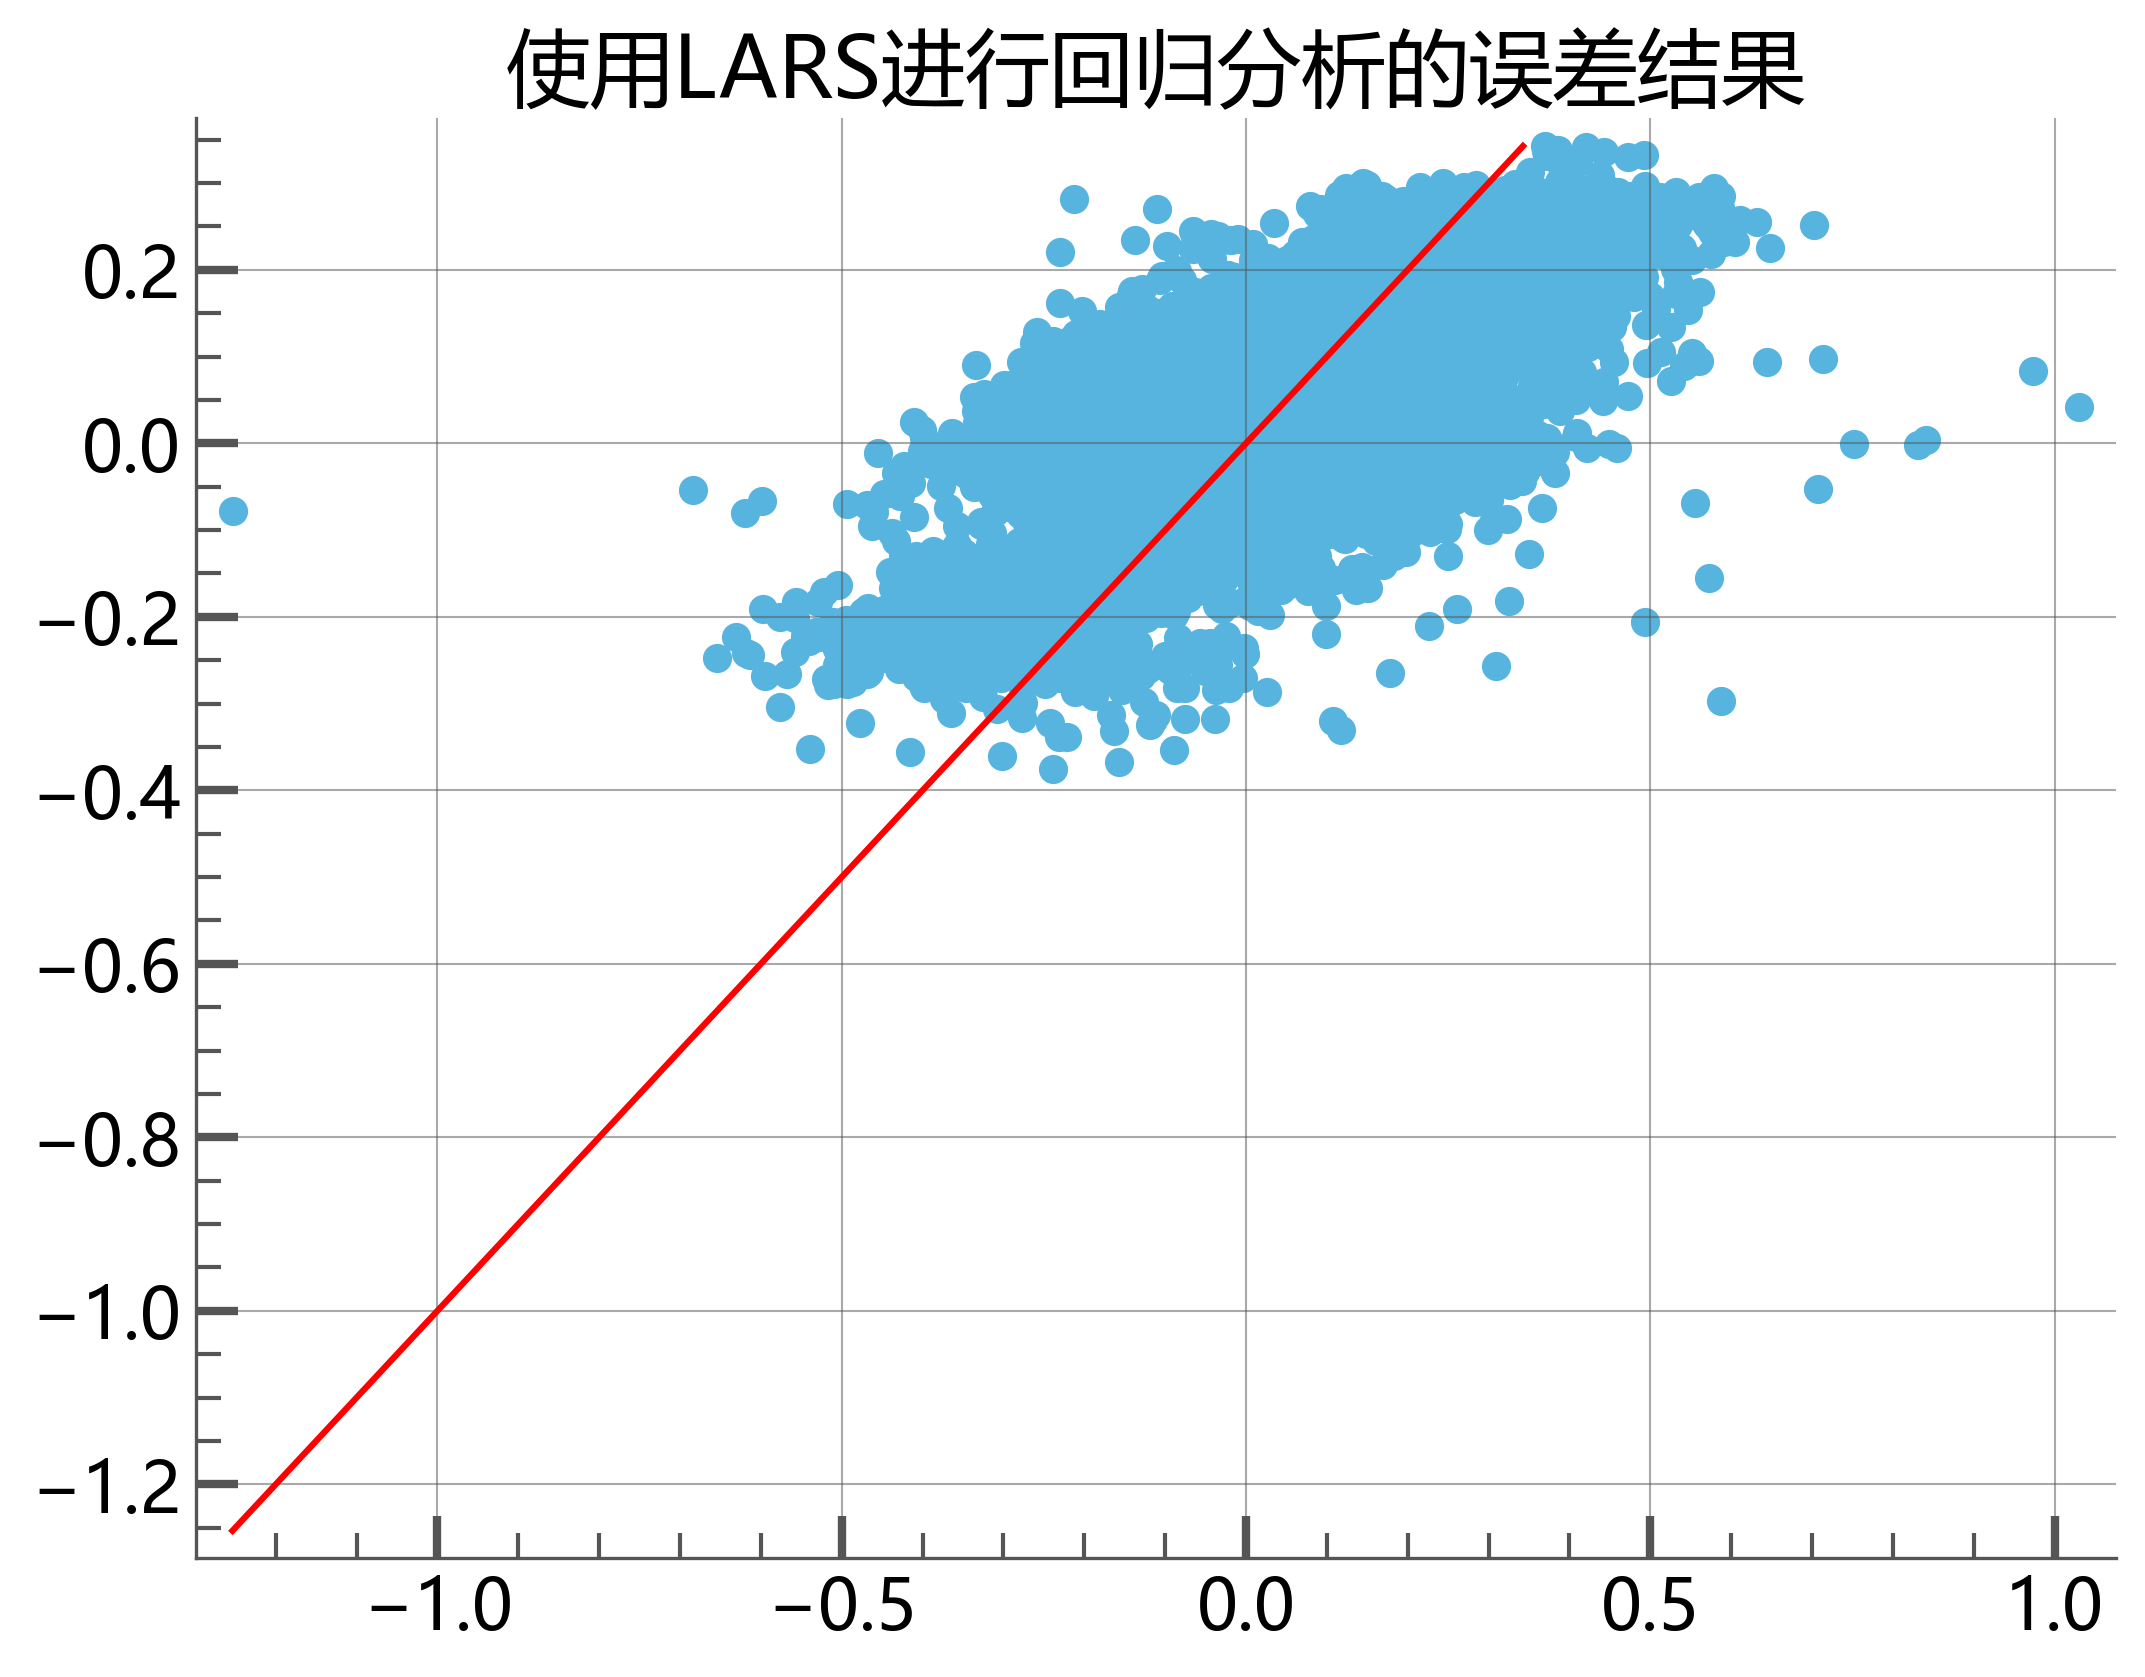

In [21]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="LARS",
).save()

figure saved at Thermal model 使用LARS进行回归分析的误差统计结果


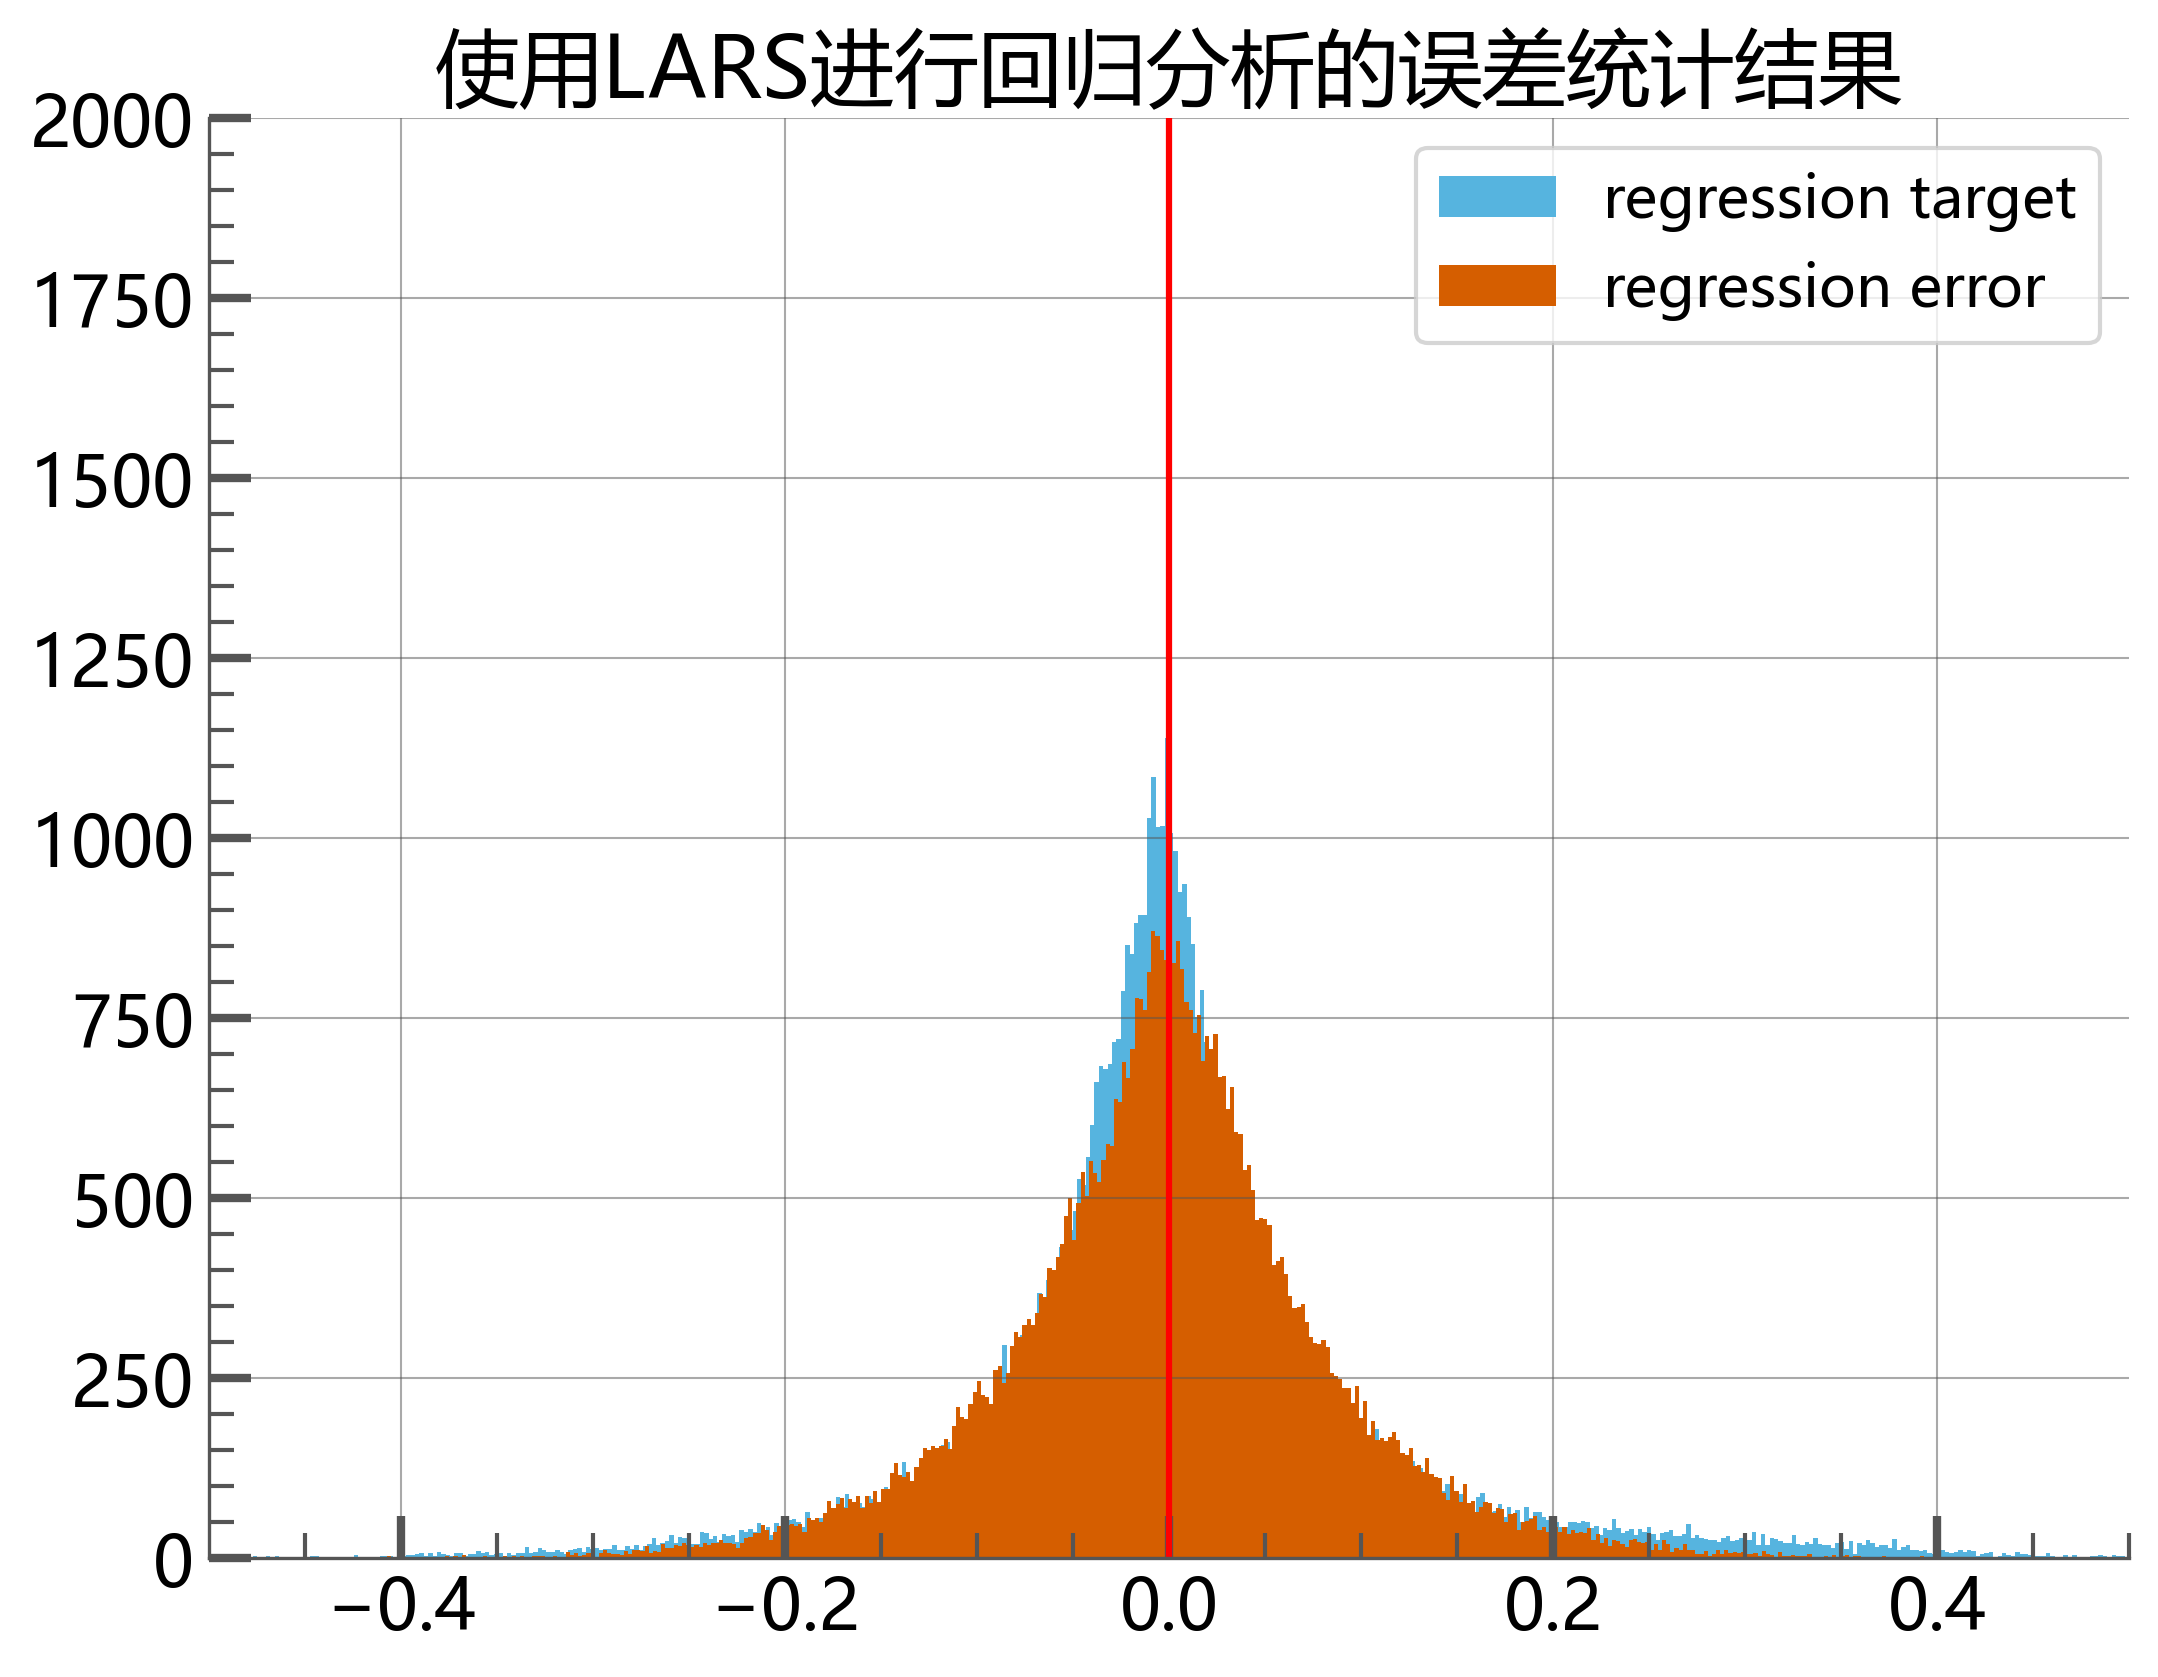

In [22]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="LARS"
).save()

figure saved at Thermal model 使用LARS进行回归的结果累计误差显示


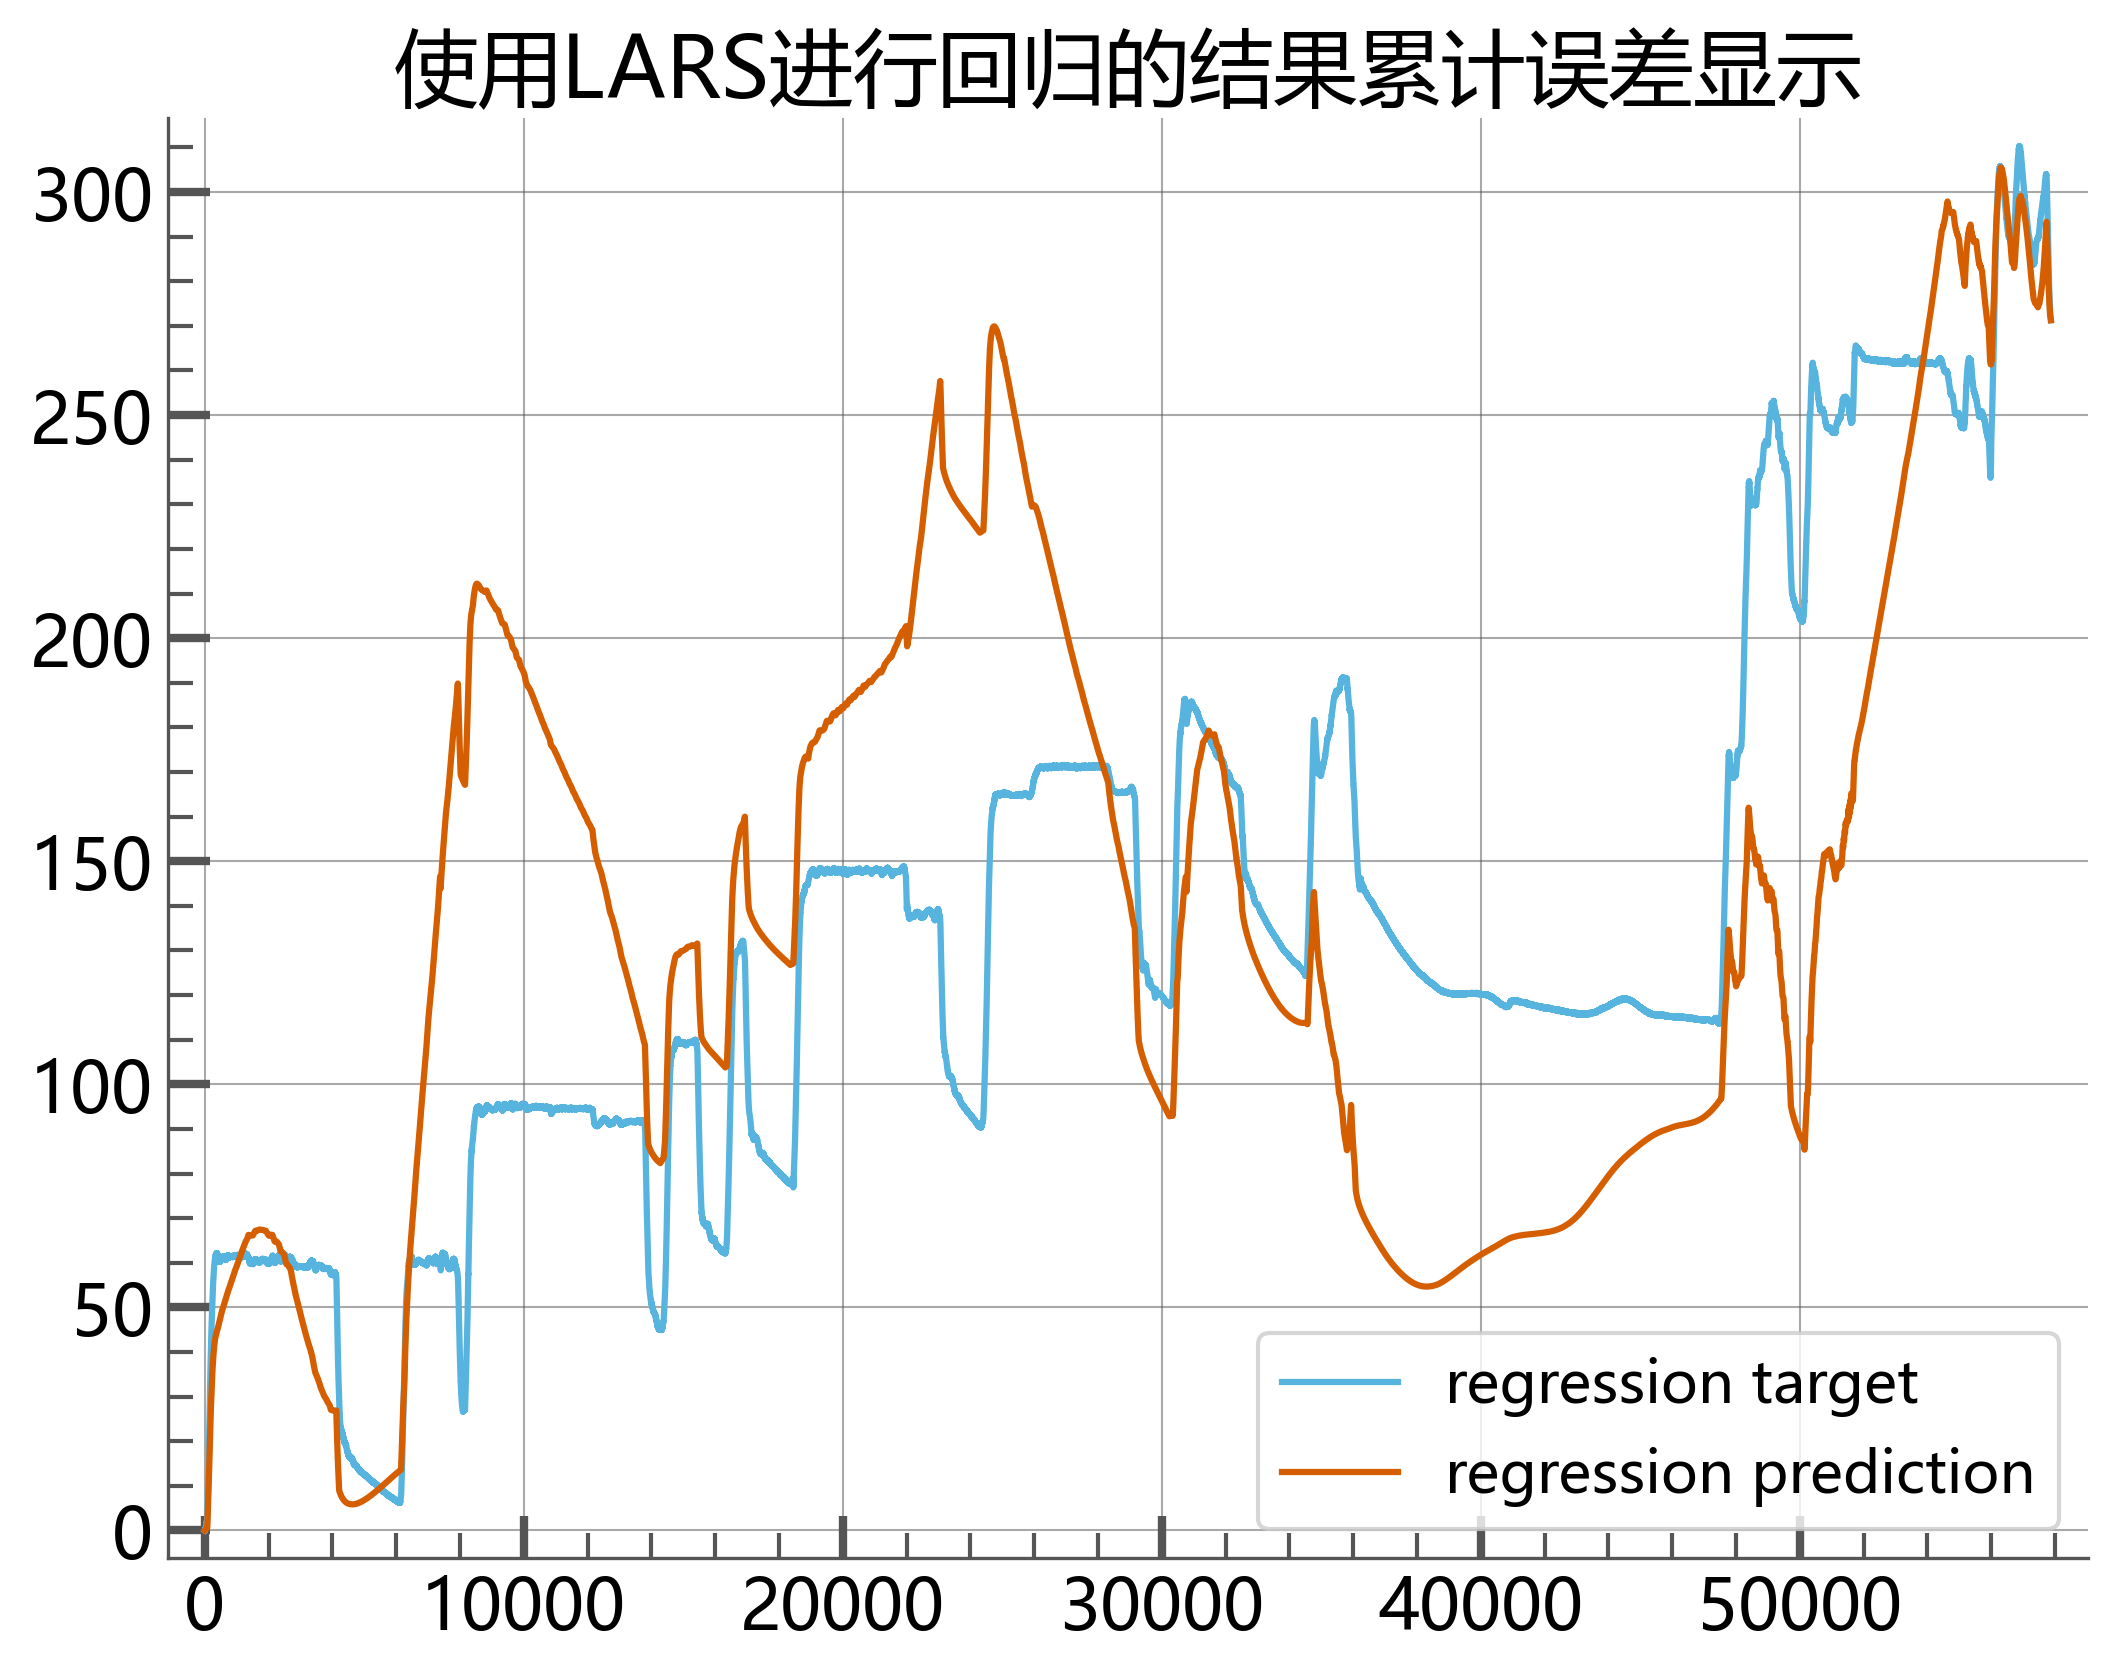

In [23]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict,
    title_model='LARS'
).save()

In [13]:
def fit_LARS(
    df_thermal_model_data_input,
):
    import warnings
    warnings.filterwarnings('ignore')
    """_summary_

    Args:
        df_thermal_model_data_input (_type_): Index(['Unnamed: 0', 'date_time', 'stack_voltage', 'stack_current', '产氢量',
       '产氢累计量', 'lye_flow', 'temp_in', 'sys_pressure', 'temp_o', 'temp_h',
       '氧侧液位', '氢侧液位', 'OTH', 'HTO', '脱氧上温', '脱氧下温', 'B塔上温', 'B塔下温', 'C塔上温',
       'C塔下温', 'A塔上温', 'A塔下温', '露点', '微氧量', '出罐压力', '进罐温度', '进罐压力', 'temp_out',
       'delta_temp', 'cell_voltage', 'current_density',
       'voltage_thermal_neutral', 'ambt_temp', 'electric_heat',
       'radiation_dissipation', 'input_lye_heat', 'output_lye_heat'],
      dtype='object')
    """
    model_input = df_thermal_model_data_input[thermal_model_input_cols]
    model_output = df_thermal_model_data_input[thermal_model_output_cols]
    model = Lars()
    model.fit(
        X = model_input,
        y = model_output,
    )
    score = model.score(model_input,model_output)
    print('---Model score of Lars is: {}'.format(
        score
    ))
    return model

In [ ]:
model_lars = fit_LARS(df_thermal_model_data_input)

# 测试模型功能

In [ ]:
from thermal_model.configs import ElectrolyzerParameter

In [ ]:
ep = ElectrolyzerParameter()

In [ ]:
ep.active_surface_area

In [ ]:
from thermal_model.original_thermal_model_and_plotter_0117 import Electrolyzer as ele_ori
from thermal_model.electrolyzer import Electrolyzer


In [ ]:
electrolyzer = Electrolyzer()
ele_ori_model = ele_ori()
ele_ori_model.merge_coef()

In [ ]:
electrolyzer.pring_all_properties()

In [ ]:
ele_ori_model.Print_All_Properties()

In [ ]:
(
            current_list,
            voltage_list,
            power_list,
            temperature_list
        ) = electrolyzer.get_default_polarization()

In [ ]:
electrolyzer.temperature_thermal_balance_current(
    ambient_temperature=15,
    lye_flow=1.5,
    lye_temperature=10,
    current=0
)